<a href="https://colab.research.google.com/github/CardosoJr/bootcamp/blob/main/Labs/Lab_18_Unsupervised_Learning_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab - Intro to Unsupervised Learning - Clustering

## Unsupervised Learning
* Não temos labels! Como aproveitar dados sem label para extrair informação? 
* Existe o caso do semi-supervised learning: uma parte dos dados com label e outra sem. 

Uma sub-área de unsupervised learning é **clustering**.

## Clustering

- Automatically organizing the data
- Labeling data
- Understanding hidden structure of data
- News Clustering for grouping similar news together
- Customer Segmentation
- Suggest social groups

In [34]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

# Importando libs de plots
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
# sns.set_context('talk')
sns.set_palette('dark')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [113]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [117]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis', edgecolor='k',zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

In [119]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

### Um introdução com dados sintéticos

In [2]:
 from sklearn.datasets import make_blobs

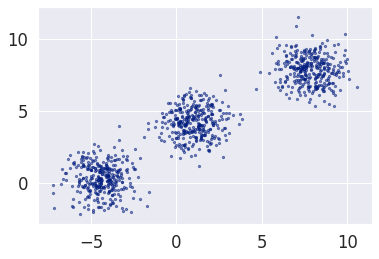

In [35]:
X,y = make_blobs(n_features=2, n_samples=1000, centers=3, cluster_std=1, random_state=3)
plt.scatter(X[:,0], X[:,1], s=5, alpha=.5);

#### Métricas de Distância

Clusterização é encontrar conjuntos de dados que se parecem entre si no mesmo cluster e que sejam diferente das amostras de outros clusters. Como medir similaridade entre amostra? Métricas de Distância

- Minkowiski: 
 
 <img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/4060cc840aeab9e41b5e47356088889e2e7a6f0f">
 
 - Manhattan (p=1), Euclidian (p=2)
 

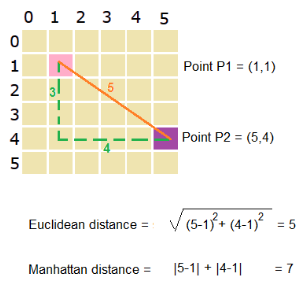

- Cosine (mais utilizado em dados de texto)
 
 <img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/1d94e5903f7936d3c131e040ef2c51b473dd071d"> 

In [4]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, manhattan_distances

In [5]:
X = [[0, 1], [1, 1]]

In [6]:
euclidean_distances(X, X)

array([[0., 1.],
       [1., 0.]])

In [7]:
euclidean_distances(X, [[0,0]])

array([[1.        ],
       [1.41421356]])

In [8]:
cosine_distances(X,X)

array([[0.        , 0.29289322],
       [0.29289322, 0.        ]])

In [9]:
manhattan_distances(X,X)

array([[0., 1.],
       [1., 0.]])

#### Podemos ver clustering como um problema de otimização
* Maximizar distâncias inter-cluster
* Minimizar distâncias intra-cluster 

#### Tipos de Clustering
* Partitioning methods
  - Partitions n data into k partitions
  - Initially, random partitions are created & gradually data is moved across different partitions.
  - It uses distance between points to optimize clusters.
  - KMeans & Meanshift are examples of Partitioning methods
* Hierarchical methods
  - These methods does hierarchical decomposition of datasets.
  - One approach is, assume each data as cluster & merge to create a bigger cluster
  - Another approach is start with one cluster & continue splitting
* Density-based methods
  - All above techniques are distance based & such methods can find only spherical clusters and not suited for clusters of other shapes.
  - Continue growing the cluster untill the density exceeds certain threashold.

#### Métodos de Partição: Kmeans

* Minimizing creteria : within-cluster-sum-of-squares.

<img src="https://github.com/awantik/machine-learning-slides/blob/master/kmeans2.png?raw=true">

* The centroids are chosen in such a way that it minimizes within cluster sum of squares.

* The k-means algorithm divides a set of $N$ samples $X$ into $K$ disjoint clusters $C$, each described by the mean  of the samples in the cluster. $\mu$

<img src="https://cssanalytics.files.wordpress.com/2013/11/cluster-image.png" width="300px">

##### KMeans Algorithm
1. Initialize k centroids.
2. Assign each data to the nearest centroid, these step will create clusters.
3. Recalculate centroid - which is mean of all data belonging to same cluster.
4. Repeat steps 2 & 3, till there is no data to reassign a different centroid.

Animation to explain algo - http://tech.nitoyon.com/en/blog/2013/11/07/k-means/

In [14]:
from sklearn.datasets import make_blobs, make_moons

In [57]:
X,y = make_blobs(n_features=2, n_samples=1000, cluster_std=.5)

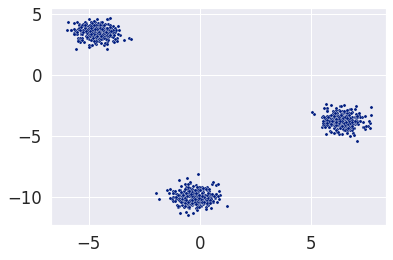

In [58]:
sns.scatterplot(X[:,0], X[:,1],s=10);

In [17]:
from sklearn.cluster import KMeans, MeanShift

In [59]:
kmeans = KMeans(n_clusters=3)

In [60]:
kmeans.fit(X)

KMeans(n_clusters=3)

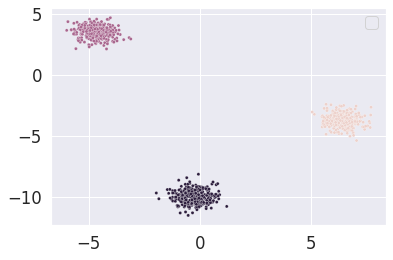

In [62]:
sns.scatterplot(X[:,0], X[:,1],s=10, hue=kmeans.predict(X));
plt.legend([]);

In [109]:
X, y = make_moons(n_samples=1000, noise=.09)

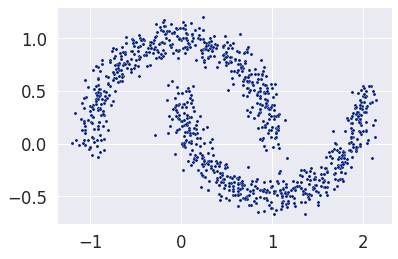

In [64]:
sns.scatterplot(X[:,0], X[:,1],s=10);

In [65]:
kmeans = KMeans(n_clusters=2)

In [66]:
kmeans.fit(X)

KMeans(n_clusters=2)

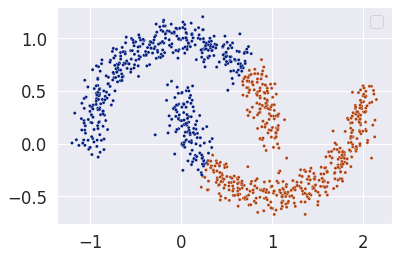

In [67]:
sns.scatterplot(X[:,0], X[:,1],s=10, hue=kmeans.predict(X));
plt.legend([]);

#### Limitations of KMeans
* Assumes that clusters are convex & behaves poorly for elongated clusters.
* Probability for participation of data to multiple clusters.
* KMeans tries to find local minima & this depends on init value.

In [116]:
rng = np.random.RandomState(13)
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X_stretched = np.dot(X, rng.randn(2, 2))

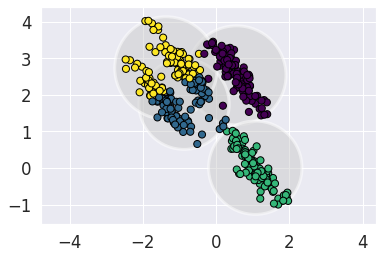

In [118]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

#### Kernels in Kmeans

The situation above is reminiscent of the Support Vector Machines, where we use a kernel transformation to project the data into a higher dimension where a linear separation is possible. We might imagine using the same trick to allow k-means to discover non-linear boundaries.

One version of this kernelized k-means is implemented in Scikit-Learn within the SpectralClustering estimator. It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a k-means algorithm:

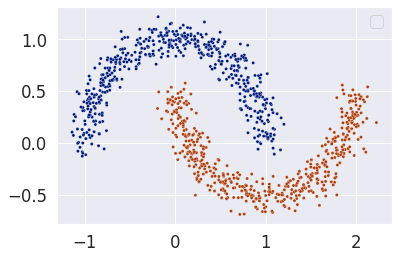

In [112]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
sns.scatterplot(X[:, 0], X[:, 1], hue=labels, s=10);
plt.legend([]);

#### Meanshift
* Centroid based clustering algorithm.
* Mode can be understood as highest density of data points.

In [69]:
centers = [[1, 1], [-.75, -1], [1, -1], [-3, 2]]
X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

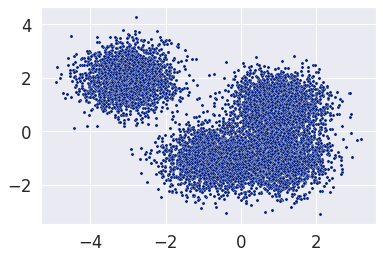

In [74]:
sns.scatterplot(X[:,0], X[:,1],s=10);

In [72]:
kmeans = KMeans(n_clusters=4)
ms = MeanShift()

In [73]:
kmeans.fit(X)
ms.fit(X)

MeanShift()

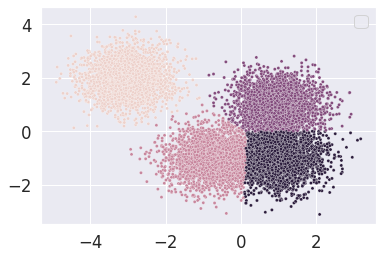

In [75]:
sns.scatterplot(X[:,0], X[:,1],s=10, hue=kmeans.predict(X))
plt.legend([]);

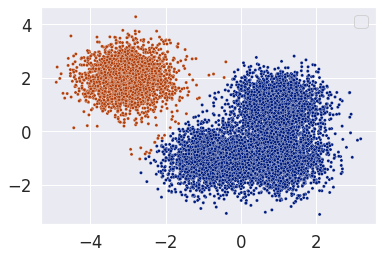

In [76]:
sns.scatterplot(X[:,0], X[:,1],s=10, hue=ms.predict(X))
plt.legend([]);

### Gaussian Mixture Models (GMMs)

Two ideas may come to mind,

* You could measure uncertainty in cluster assignment by comparing the distances of each point to all cluster centers, rather than focusing on just the closest.
* You might also imagine allowing the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters.
A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means.

However, because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the predict_proba method. This returns a matrix of size [n_samples, n_clusters] which measures the probability that any point belongs to the given cluster.

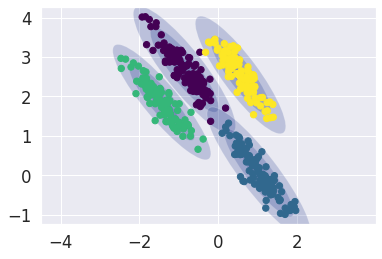

In [120]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

#### Hierarchial Clustering
* A method of clustering where you combine similar clusters to create a cluster or split a cluster into smaller clusters such they now they become better.
* Two types of hierarchaial Clustering
  - Agglomerative method, a botton-up approach.
  - Divisive method, a top-down approach.

##### Agglomerative method

It works by first putting each data point in their own cluster and then merging clusters based on some rule, until there are only the wanted number of clusters remaining. For this to work, there needs to be a distance measure between the data points. With this distance measure `d`, we can define another distance measure between the **clusters** U and V using one of the following methods (*linkages*):

* Start with assigning one cluster to each data. 
* Combine clusters which have higher similarity.
* Differences between methods arise due to different ways of defining distance (or similarity) between clusters. The following sections describe several agglomerative techniques in detail.
  * `single`: $d(U, V) := \min_{u \in U, v \in V} d(u,v)$
  * `complete`: $d(U, V) := \max_{u \in U, v \in V} d(u,v)$
  * `average`: $d(U, V) := \sum_{u \in U, v \in V} \frac{d(u,v)}{|U||V|}$
  * `ward`: tries to minimize the variance in each cluster

At each iteration of the algorithm two clusters that are closest to each other are merged. After this the distance between the clusters are recomputed, and then it continues to the next iteration.


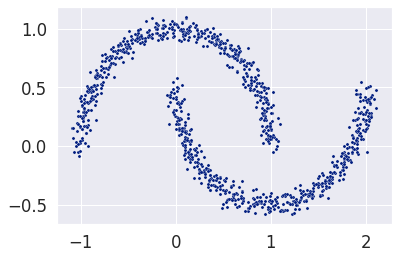

In [121]:
X, y = make_moons(n_samples=1000, noise=.05)
sns.scatterplot(X[:,0], X[:,1],s=10);

In [78]:
from sklearn.cluster import AgglomerativeClustering

In [79]:
agc = AgglomerativeClustering(linkage='single')

In [80]:
agc.fit(X)

AgglomerativeClustering(linkage='single')

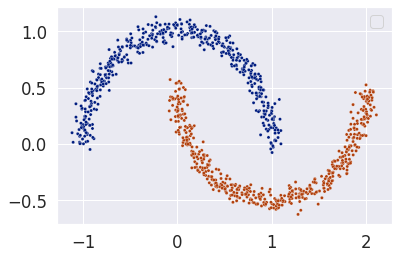

In [83]:
sns.scatterplot(X[:,0], X[:,1],s=10,hue=agc.labels_)
plt.legend([]);

#### Density Based Clustering - DBSCAN

- Fundamentally, all clustering methods use the same approach i.e. first we calculate similarities and then we use it to cluster the data points into groups or batches. 
-  To run DB Scan, it doesn’t require an input for the number of clusters 
- But **DBSCAN does need to tune three other parameters**
  1.  **'eps' parameter** 
    - Same as Radius of the circle
    - It is the maximum distance between two data points to be considered in the same neighborhood
    - It defines the neighborhood around a data point i.e. if the distance between two points is lower or equal to ‘eps’ then they are considered as neighbors.
    - If the eps value is chosen too small then large part of the data will be considered as outliers. If it is chosen very large then the clusters will merge and majority of the data points will be in the same clusters. 
    - One way to **find the eps value is based on the k-distance graph**
  2. **'min_samples' parameter** 
    - It is the minimum amount of data points in a neighborhood to be considered a cluster
    - Minimum number of neighbors (data points) within eps radius. Larger the dataset, the larger value of MinPts must be chosen. 
    - As a general rule, the minimum MinPts can be derived from the number of dimensions D in the dataset as, MinPts >= D+1.
    - The minimum value of MinPts must be chosen at least 3.
  3. **'metric' parameter**
    - The metric to use when calculating distance between instances in a feature array (i.e. euclidean distance).

- The key idea is that for each point of a cluster, the neighborhood of a given radius has to contain at least a minimum number of points. 


- In this algorithm, **we have 3 types of data points.**
  1. **Core Point:** A point is a core point if it has more than MinPts points within eps(radius). 
  2. **Border Point:** A point which has fewer than MinPts within eps but it is in the neighborhood of a core point. 
  3. **Noise or outlier:** A point which is not a core point or border point.


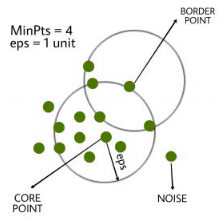

In [84]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

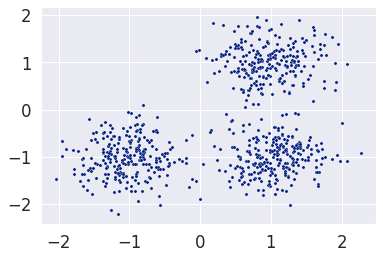

In [85]:
sns.scatterplot(X[:,0], X[:,1],s=10);

In [86]:
from sklearn.cluster import DBSCAN

In [87]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

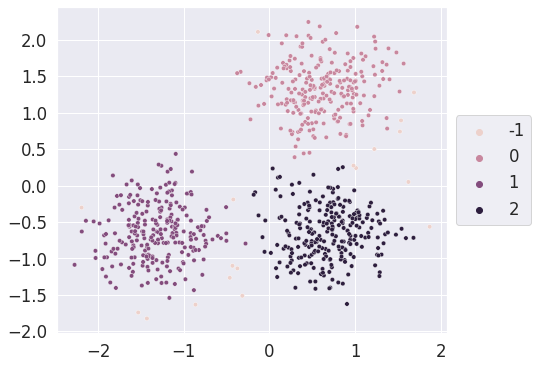

In [94]:
fig, ax = plt.subplots(figsize = (7,6))
sns.scatterplot(X[:,0], X[:,1],s=20,hue=labels);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [128]:
import math
import matplotlib
np.random.seed(42)
def PointsInCircum(r,n=100):
    return [(math.cos(2*math.pi/n*x)*r+np.random.normal(-30,30),math.sin(2*math.pi/n*x)*r+np.random.normal(-30,30)) for x in range(1,n+1)]

# Creating data points in the form of a circle
df=pd.DataFrame(PointsInCircum(500,1000))
df=df.append(PointsInCircum(300,700))
df=df.append(PointsInCircum(100,300))

df=df.append([(np.random.randint(-600,600),np.random.randint(-600,600)) for i in range(300)])

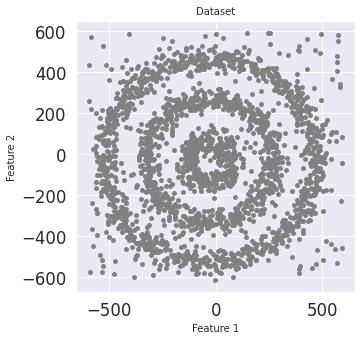

In [125]:
plt.figure(figsize=(5,5))
plt.scatter(df[0],df[1],s=15,color='grey')
plt.title('Dataset',fontsize=10)
plt.xlabel('Feature 1',fontsize=10)
plt.ylabel('Feature 2',fontsize=10)
plt.show()

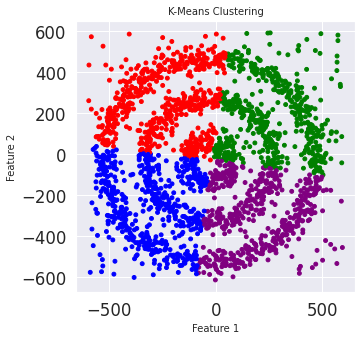

In [129]:
k_means=KMeans(n_clusters=4,random_state=42)
k_means.fit(df[[0,1]])

df['KMeans_labels']=k_means.labels_

colors=['purple','red','blue','green']
plt.figure(figsize=(5,5))
plt.scatter(df[0],df[1],c=df['KMeans_labels'],cmap=matplotlib.colors.ListedColormap(colors),s=15)
plt.title('K-Means Clustering',fontsize=10)
plt.xlabel('Feature 1',fontsize=10)
plt.ylabel('Feature 2',fontsize=10)
plt.show()

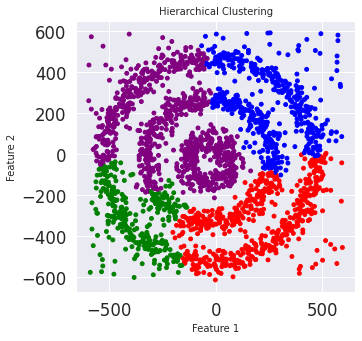

In [130]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean')
model.fit(df[[0,1]])

df['HR_labels']=model.labels_

plt.figure(figsize=(5,5))
plt.scatter(df[0],df[1],c=df['HR_labels'],cmap=matplotlib.colors.ListedColormap(colors),s=15)
plt.title('Hierarchical Clustering',fontsize=10)
plt.xlabel('Feature 1',fontsize=10)
plt.ylabel('Feature 2',fontsize=10)
plt.show()

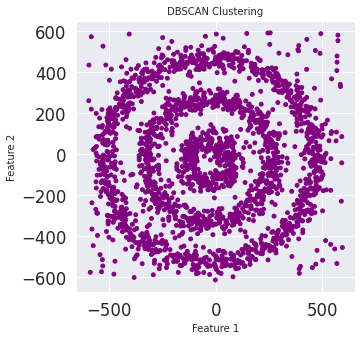

In [131]:
dbscan=DBSCAN()
dbscan.fit(df[[0,1]]) #epsilon is 0.5,  min_samples 5

# DB Scan Plot
df['DBSCAN_labels']=dbscan.labels_ 

# Plotting resulting clusters
plt.figure(figsize=(5,5))
plt.scatter(df[0],df[1],c=df['DBSCAN_labels'],cmap=matplotlib.colors.ListedColormap(colors),s=15)
plt.title('DBSCAN Clustering',fontsize=10)
plt.xlabel('Feature 1',fontsize=10)
plt.ylabel('Feature 2',fontsize=10)
plt.show()

Vamos utilizar o k-distance graph para ajudar a determinar o valor de eps

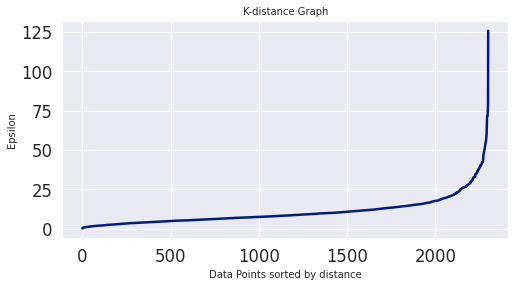

In [134]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df[[0,1]])
distances, indices = nbrs.kneighbors(df[[0,1]])

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(8,4))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=10)
plt.xlabel('Data Points sorted by distance',fontsize=10)
plt.ylabel('Epsilon',fontsize=10)
plt.show()

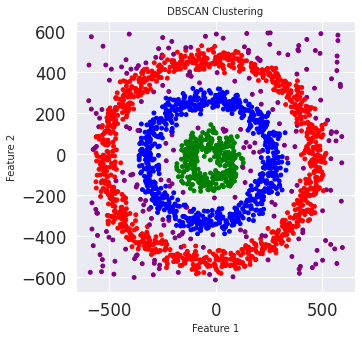

In [133]:
dbscan_opt=DBSCAN(eps=30,min_samples=6)
dbscan_opt.fit(df[[0,1]])

df['DBSCAN_opt_labels']=dbscan_opt.labels_
df['DBSCAN_opt_labels'].value_counts()

# Plotting the resulting clusters
plt.figure(figsize=(5,5))
plt.scatter(df[0],df[1],c=df['DBSCAN_opt_labels'],cmap=matplotlib.colors.ListedColormap(colors),s=15)
plt.title('DBSCAN Clustering',fontsize=10)
plt.xlabel('Feature 1',fontsize=10)
plt.ylabel('Feature 2',fontsize=10)
plt.show()

### Measuring Performance of Clusters
* Two forms of evaluation 
* supervised, which uses a ground truth class values for each sample.
  - completeness_score
  - homogeneity_score
* unsupervised, which measures the quality of model itself
  - silhoutte_score
  - calinski_harabaz_score

#### **completeness_score**
- A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.
- Accuracy is 1.0 if data belonging to same class belongs to same cluster, even if multiple classes belongs to same cluster

In [95]:
from sklearn.metrics.cluster import completeness_score

In [96]:
completeness_score( labels_true=[10,10,11,11],labels_pred=[1,1,0,0])

1.0

* The acuracy is 1.0 because all the data belonging to same class belongs to same cluster

#### **homogeneity_score**
- A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.

In [97]:
from sklearn.metrics.cluster import homogeneity_score

In [98]:
homogeneity_score([0, 0, 1, 1], [1, 1, 0, 0])

1.0

In [99]:
homogeneity_score([0, 0, 1, 1], [0, 1, 2, 3])

0.9999999999999999

In [100]:
homogeneity_score([0, 0, 0, 0], [1, 1, 0, 0])

1.0

#### **silhoutte_score**
* The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample.
* The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of.

In [101]:
from sklearn.datasets import make_blobs
X, Y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)

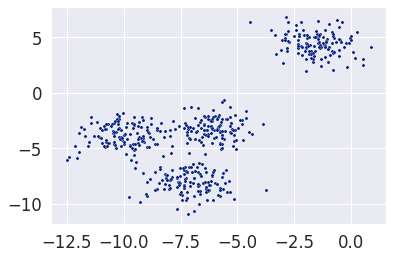

In [103]:
sns.scatterplot(X[:,0],X[:,1],s=10);

In [104]:
range_n_clusters = [2, 3, 4, 5, 6]

In [105]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [106]:
for n_cluster in range_n_clusters:
    kmeans = KMeans(n_clusters=n_cluster)
    kmeans.fit(X)
    labels = kmeans.predict(X)
    print (n_cluster, silhouette_score(X,labels))

2 0.7049787496083262
3 0.5882004012129721
4 0.6505186632729437
5 0.5748362978270065
6 0.5141489067073599


#### **Elbow Method**
- In the Elbow method, we are actually varying the number of clusters (K) from 1 – 10. For each value of K, we are calculating WCSS(Within-Cluster Sum of Square)
- **WCSS is the sum of squared distance between each point and the centroid in a cluster**
- WCSS value is largest when K = 1. 

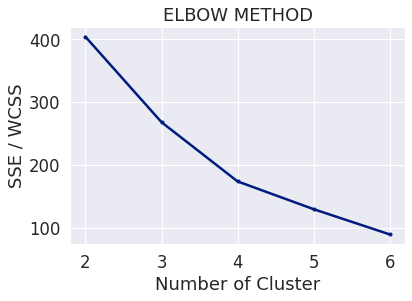

In [122]:
scores = []

for n_cluster in range_n_clusters:
    kmeans = KMeans(n_clusters=n_cluster)
    kmeans.fit(X)
    scores.append(kmeans.inertia_)

plt.figure()
plt.plot(range_n_clusters, scores,'.-')
plt.xlabel("Number of Cluster")
plt.ylabel("SSE / WCSS")
plt.title("ELBOW METHOD")
plt.show()

#### **calinski_harabaz_score**
* The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion.

In [108]:
from sklearn.metrics import calinski_harabasz_score

for n_cluster in range_n_clusters:
    kmeans = KMeans(n_clusters=n_cluster)
    kmeans.fit(X)
    labels = kmeans.predict(X)
    print (n_cluster, calinski_harabasz_score(X,labels))

2 1604.112286409658
3 1809.991966958033
4 2704.4858735121097
5 2281.8610165161376
6 2035.7013876858766
